<a href="https://colab.research.google.com/github/ANANDA-SWAROOP/aiml_project/blob/main/heirarchical_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install scikit-learn-extra


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 25.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-learn-extra: filename=scikit_learn_extra-0.3.0-cp312-cp312-linux_x86_64.whl size=2177961 sha256=9de67f5f71f0033b7ee797c531abe7ba78229e69e8f4b789768eccf1d133e41c
  Stored in directory: /root/.cache/pip/wheels/17/4d/c3/c6d5d563c1bf8146d059d63be3678abc2f2801fba0aaf5f0b8
Successfully built scikit-learn-extra


In [1]:
# Install scikit-learn-extra if not already installed
# !pip install scikit-learn-extra

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import pairwise_distances_argmin_min

# -----------------------------
# STEP 1: Generate synthetic data
# -----------------------------
X, y_true = make_blobs(
    n_samples=300,
    centers=4,
    cluster_std=0.60,
    random_state=0
)

# -----------------------------
# STEP 2: Fit K-Medoids model
# -----------------------------
kmedoids = KMedoids(n_clusters=4, random_state=0, metric='euclidean')
kmedoids.fit(X)

# -----------------------------
# STEP 3: Extract results
# -----------------------------
labels = kmedoids.labels_
medoid_indices = kmedoids.medoid_indices_
medoids = kmedoids.cluster_centers_

# -----------------------------
# STEP 4: Visualize clusters
# -----------------------------
plt.figure(figsize=(8,6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)
plt.scatter(medoids[:, 0], medoids[:, 1], c='red', marker='D', s=200, label='Medoids')
plt.title("K-Medoids Clustering Visualization")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

# -----------------------------
# STEP 5: Visualize cluster boundaries (optional)
# -----------------------------
# Create a mesh grid for decision boundary visualization
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

# Predict cluster labels for each grid point
Z = kmedoids.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, cmap='viridis', alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50)
plt.scatter(medoids[:, 0], medoids[:, 1], c='red', marker='D', s=200, label='Medoids')
plt.title("K-Medoids Decision Boundaries")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

# -----------------------------
# STEP 6: Display distances of points to medoids
# -----------------------------
closest, distances = pairwise_distances_argmin_min(medoids, X)
print("Medoid Indices:", medoid_indices)
print("Medoid Coordinates:\n", medoids)


ModuleNotFoundError: No module named 'sklearn_extra'

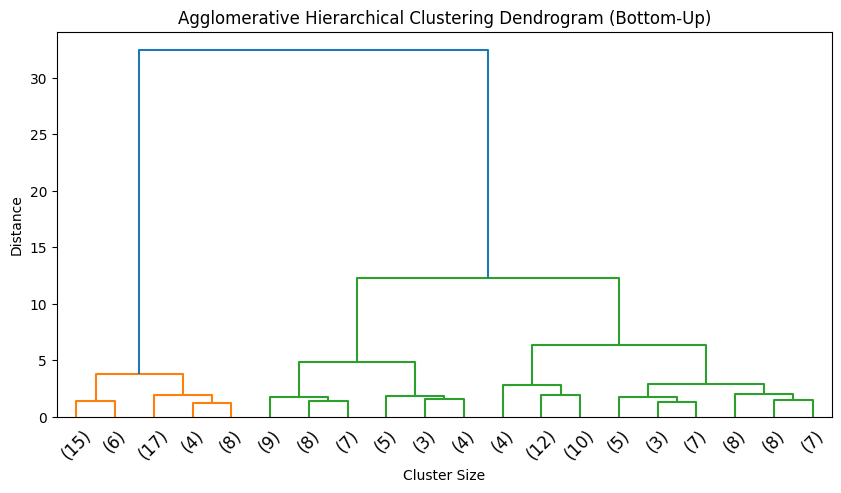

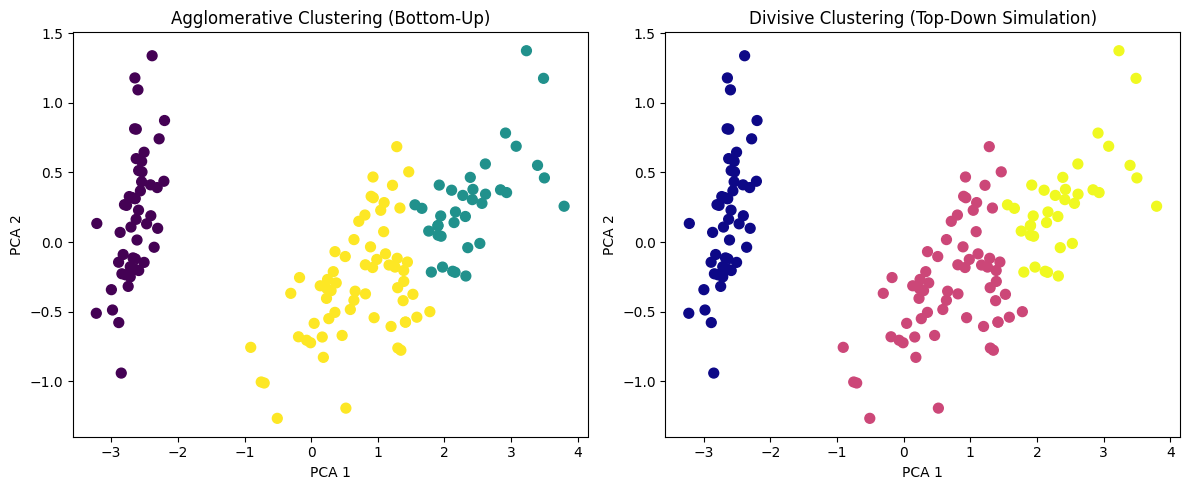

Silhouette Score (Agglomerative): 0.554
Silhouette Score (Divisive Simulation): 0.554


In [5]:
# -----------------------------
# Hierarchical Clustering: Agglomerative (Bottom-Up) & Divisive (Top-Down Simulation)
# -----------------------------
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# -----------------------------
# STEP 1: Load dataset (Iris)
# -----------------------------
iris = load_iris()
X = iris.data
y = iris.target

# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# -----------------------------
# STEP 2: Agglomerative Clustering (Bottom-Up)
# -----------------------------
linked = linkage(X, method='ward')

plt.figure(figsize=(10, 5))
dendrogram(linked, truncate_mode='lastp', p=20, leaf_rotation=45.)
plt.title("Agglomerative Hierarchical Clustering Dendrogram (Bottom-Up)")
plt.xlabel("Cluster Size")
plt.ylabel("Distance")
plt.show()

# Assign clusters (3 clusters)
clusters_agg = fcluster(linked, t=3, criterion='maxclust')

# -----------------------------
# STEP 3: Divisive Clustering (Top-Down Simulation, FIXED)
# -----------------------------
def divisive_clustering(X, k):
    """
    Simulate divisive clustering by recursively splitting
    clusters using AgglomerativeClustering (n_clusters=2).
    """
    # Initially, one cluster with all indices
    clusters = [np.arange(len(X))]

    while len(clusters) < k:
        # Select cluster with highest variance
        variances = [np.var(X[c], axis=0).sum() for c in clusters]
        idx_to_split = np.argmax(variances)
        cluster_to_split = clusters.pop(idx_to_split)

        # Split it into two subclusters
        if len(cluster_to_split) < 2:
            clusters.append(cluster_to_split)
            continue

        model = AgglomerativeClustering(n_clusters=2)
        sub_labels = model.fit_predict(X[cluster_to_split])

        clusters.append(cluster_to_split[sub_labels == 0])
        clusters.append(cluster_to_split[sub_labels == 1])

    # Assign final labels
    labels = np.zeros(len(X), dtype=int)
    for i, c in enumerate(clusters):
        labels[c] = i

    return labels

clusters_div = divisive_clustering(X, 3)

# -----------------------------
# STEP 4: Visualization
# -----------------------------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters_agg, cmap='viridis', s=50)
plt.title("Agglomerative Clustering (Bottom-Up)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

plt.subplot(1,2,2)
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters_div, cmap='plasma', s=50)
plt.title("Divisive Clustering (Top-Down Simulation)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

plt.tight_layout()
plt.show()

# -----------------------------
# STEP 5: Metrics
# -----------------------------
print("Silhouette Score (Agglomerative):", round(silhouette_score(X, clusters_agg), 3))
print("Silhouette Score (Divisive Simulation):", round(silhouette_score(X, clusters_div), 3))


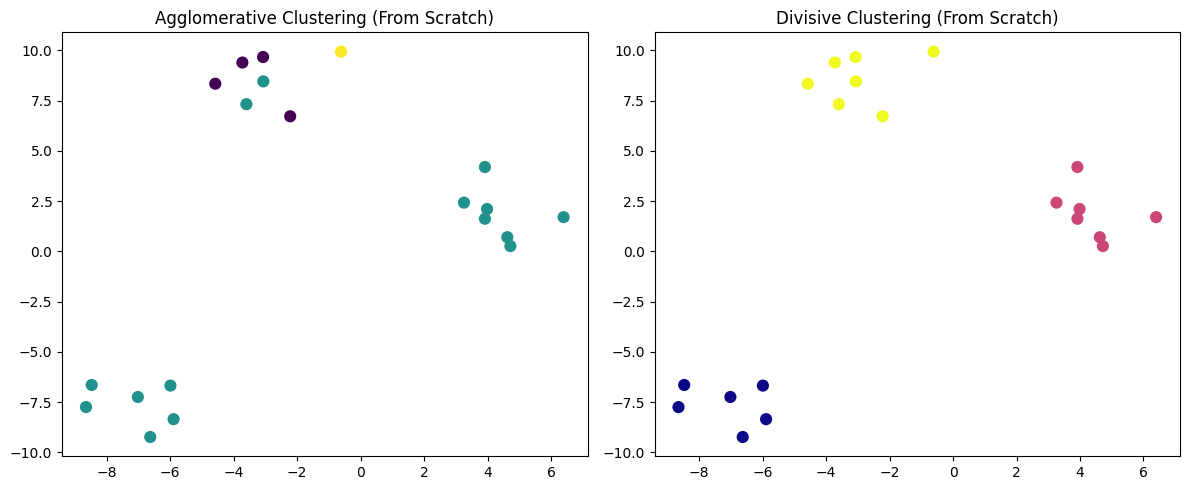

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.datasets import make_blobs

# Generate dataset
X, _ = make_blobs(n_samples=20, centers=3, random_state=42, cluster_std=1.2)

# -----------------------------
# AGGLOMERATIVE CLUSTERING (Bottom-Up)
# -----------------------------
def agglomerative_clustering(X, k):
    clusters = [[i] for i in range(len(X))]
    distances = cdist(X, X, 'euclidean')
    np.fill_diagonal(distances, np.inf)

    while len(clusters) > k:
        # find closest pair
        i, j = np.unravel_index(np.argmin(distances), distances.shape)
        clusters[i].extend(clusters[j])
        clusters.pop(j)

        # update distance matrix
        distances = cdist([X[np.mean(c, axis=0).astype(int)] for c in clusters],
                          [X[np.mean(c, axis=0).astype(int)] for c in clusters])
        np.fill_diagonal(distances, np.inf)

    labels = np.zeros(len(X), dtype=int)
    for idx, c in enumerate(clusters):
        for point in c:
            labels[point] = idx
    return labels

# -----------------------------
# DIVISIVE CLUSTERING (Top-Down)
# -----------------------------
def divisive_clustering(X, k):
    clusters = [np.arange(len(X))]
    while len(clusters) < k:
        # Find cluster with highest variance to split
        variances = [np.var(X[c], axis=0).sum() for c in clusters]
        idx_to_split = np.argmax(variances)
        cluster_to_split = clusters.pop(idx_to_split)

        # Split it into 2 using K-Means (2 means)
        from sklearn.cluster import KMeans
        kmeans = KMeans(n_clusters=2, n_init=10, random_state=0)
        sub_labels = kmeans.fit_predict(X[cluster_to_split])

        clusters.append(cluster_to_split[sub_labels == 0])
        clusters.append(cluster_to_split[sub_labels == 1])

    labels = np.zeros(len(X), dtype=int)
    for idx, c in enumerate(clusters):
        labels[c] = idx
    return labels

# -----------------------------
# Visualization
# -----------------------------
labels_agg = agglomerative_clustering(X, 3)
labels_div = divisive_clustering(X, 3)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(X[:,0], X[:,1], c=labels_agg, cmap='viridis', s=60)
plt.title("Agglomerative Clustering (From Scratch)")

plt.subplot(1,2,2)
plt.scatter(X[:,0], X[:,1], c=labels_div, cmap='plasma', s=60)
plt.title("Divisive Clustering (From Scratch)")

plt.tight_layout()
plt.show()


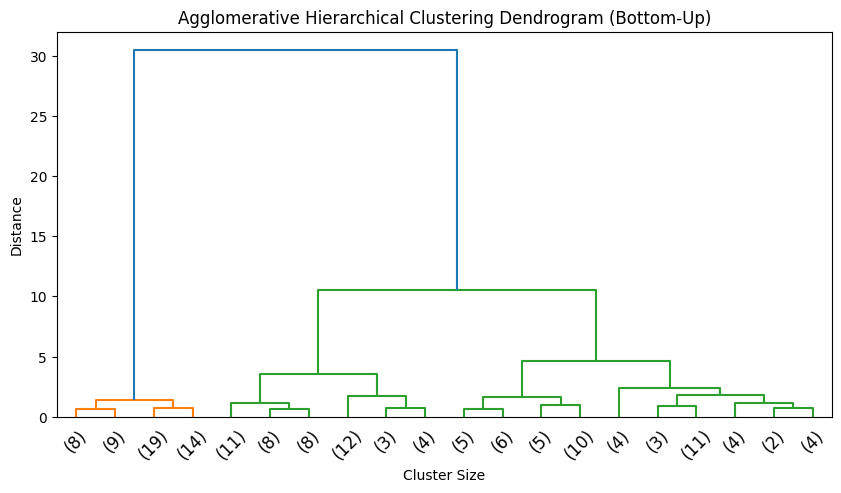

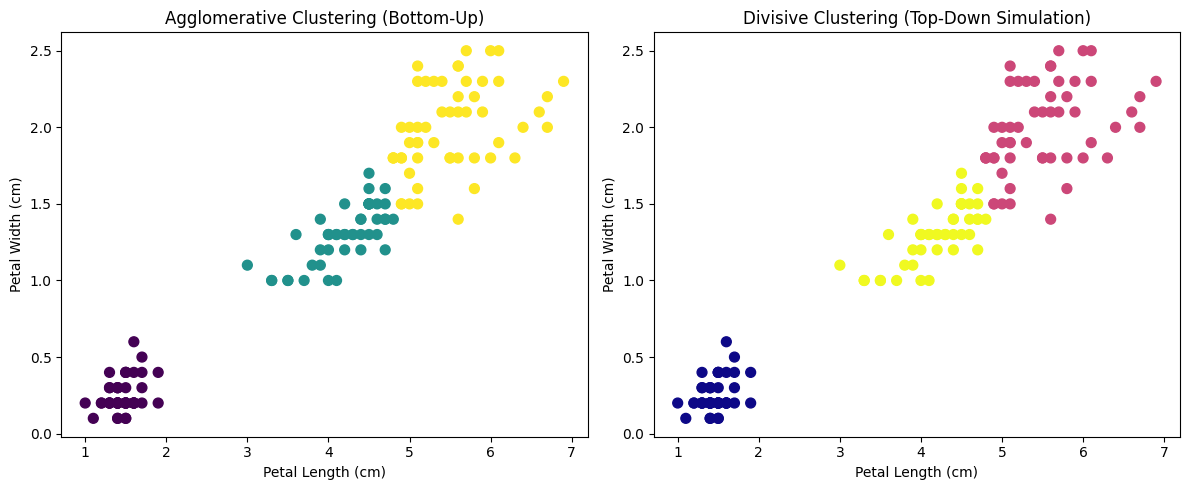

Silhouette Score (Agglomerative): 0.657
Silhouette Score (Divisive Simulation): 0.657


In [6]:
# -----------------------------
# Hierarchical Clustering on Iris dataset
# Using only Petal Length and Petal Width (no PCA)
# -----------------------------
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# -----------------------------
# STEP 1: Load Iris dataset
# -----------------------------
iris = load_iris()
X = iris.data[:, 2:4]  # Only Petal Length and Petal Width
y = iris.target

# -----------------------------
# STEP 2: Agglomerative Clustering (Bottom-Up)
# -----------------------------
linked = linkage(X, method='ward')

# Plot dendrogram
plt.figure(figsize=(10, 5))
dendrogram(linked, truncate_mode='lastp', p=20, leaf_rotation=45.)
plt.title("Agglomerative Hierarchical Clustering Dendrogram (Bottom-Up)")
plt.xlabel("Cluster Size")
plt.ylabel("Distance")
plt.show()

# Create clusters (3 clusters)
clusters_agg = fcluster(linked, t=3, criterion='maxclust')

# -----------------------------
# STEP 3: Divisive Clustering (Top-Down Simulation)
# -----------------------------
def divisive_clustering(X, k):
    """
    Simulated divisive (top-down) clustering using recursive
    splitting with AgglomerativeClustering (2 subclusters each time).
    """
    clusters = [np.arange(len(X))]

    while len(clusters) < k:
        # Choose cluster with maximum variance
        variances = [np.var(X[c], axis=0).sum() for c in clusters]
        idx_to_split = np.argmax(variances)
        cluster_to_split = clusters.pop(idx_to_split)

        # Avoid splitting very small clusters
        if len(cluster_to_split) < 2:
            clusters.append(cluster_to_split)
            continue

        model = AgglomerativeClustering(n_clusters=2)
        sub_labels = model.fit_predict(X[cluster_to_split])

        clusters.append(cluster_to_split[sub_labels == 0])
        clusters.append(cluster_to_split[sub_labels == 1])

    # Assign final labels
    labels = np.zeros(len(X), dtype=int)
    for i, c in enumerate(clusters):
        labels[c] = i
    return labels

clusters_div = divisive_clustering(X, 3)

# -----------------------------
# STEP 4: Visualization
# -----------------------------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(X[:,0], X[:,1], c=clusters_agg, cmap='viridis', s=50)
plt.title("Agglomerative Clustering (Bottom-Up)")
plt.xlabel("Petal Length (cm)")
plt.ylabel("Petal Width (cm)")

plt.subplot(1,2,2)
plt.scatter(X[:,0], X[:,1], c=clusters_div, cmap='plasma', s=50)
plt.title("Divisive Clustering (Top-Down Simulation)")
plt.xlabel("Petal Length (cm)")
plt.ylabel("Petal Width (cm)")

plt.tight_layout()
plt.show()

# -----------------------------
# STEP 5: Metrics
# -----------------------------
print("Silhouette Score (Agglomerative):", round(silhouette_score(X, clusters_agg), 3))
print("Silhouette Score (Divisive Simulation):", round(silhouette_score(X, clusters_div), 3))
